<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap11-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datenbasierter Ansatz


In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [4]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/ml-for-business/raw/main/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

# Schritt 0: Kann das überhaupt klappen?

## Anforderungen
- 150$ Profit pro Antrag!
- Mindestens 1/3 aller Anträge bekommen eine Versicherung

In [5]:
minimun_insurance_rate =  1/3
mimimum_profit_per_case = 150

## Annahmen

![](https://github.com/DJCordhose/ml-for-business/blob/main/img/kpi_matrix.jpg?raw=1)

- **Richtig Positive** würden jeweils einen Gewinn von \$1.000 erzeugen, weil es sich um Kunden handelt, die korrekt als gute Risiken identifiziert wurden, was zu profitablen Geschäften führt.
- **Falsch Positive** würden jeweils \$5.000 kosten, weil es sich um Fälle handelt, bei denen das Geschäft durch Ansprüche, die die Prämien übersteigen, verloren geht.
- **Falsch Negative** würden jeweils \$1.000 kosten und den verlorenen Gewinn aus einem guten Kunden darstellen, der fälschlicherweise abgewiesen wurde.
- **Richtig Negative** erzeugen keinen direkten Umsatz (da keine Versicherungspolice ausgestellt wird), haben jedoch eine positive finanzielle Auswirkung, indem potenzielle Kosten vermieden werden, allerdings ist es schwieriger, einen direkten monetären Wert zuzuweisen, daher wird dies hier nicht berücksichtigt.

Das Ziel ist es, die Anzahl der richtig positiven Fälle zu maximieren und gleichzeitig die Anzahl der falsch positiven und falsch negativen Fälle zu minimieren.



https://en.wikipedia.org/wiki/Precision_and_recall

1. **Richtig Positiv (tp)**: Die Anzahl der Fälle, in denen der Klassifikator korrekt vorhergesagt hat, dass einem Kunden eine Versicherung gewährt werden sollte (d.h., der Kunde war ein gutes Risiko und der Klassifikator sagte 'ja').

2. **Falsch Positiv (fp)**: Die Anzahl der Fälle, in denen der Klassifikator fälschlicherweise vorhergesagt hat, dass einem Kunden eine Versicherung gewährt werden sollte (d.h., der Kunde war tatsächlich ein schlechtes Risiko, aber der Klassifikator sagte 'ja'). Dies ist kostspielig, da es einen Verlust für das Unternehmen darstellt, weil Versicherungsansprüche zu leisten sind.

3. **Richtig Negativ (tn)**: Die Anzahl der Fälle, in denen der Klassifikator korrekt vorhergesagt hat, dass einem Kunden keine Versicherung gewährt werden sollte (d.h., der Kunde war ein schlechtes Risiko und der Klassifikator sagte 'nein').

4. **Falsch Negativ (fn)**: Die Anzahl der Fälle, in denen der Klassifikator fälschlicherweise vorhergesagt hat, dass einem Kunden keine Versicherung gewährt werden sollte (d.h., der Kunde war tatsächlich ein gutes Risiko, aber der Klassifikator sagte 'nein'). Dies stellt eine verpasste Gelegenheit dar, bei der das Unternehmen Geschäft von einem guten Kunden verpasst.


In [6]:
# costs and benefits
cost_fp = 5_000  # cost of a false positive
reward_tp = 1000  # reward of a true positive
cost_fn = 1000  # cost of a false negative

## Wir machen Annahmen für die Verteilung der Fälle

In [7]:
# das ist total aus den Fingern gesaugt, könnte aber auch anhand von allgemeinen Statistiken ermittelt werden
tn, fn, fp, tp = 45, 5, 5, 45

In [8]:
all_cases = tn + fp + fn + tp

In [9]:
rate_people_getting_insurance = (tp + fp) / all_cases
rate_people_getting_insurance

0.5

In [10]:
assert rate_people_getting_insurance > minimun_insurance_rate

In [11]:
kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
kpi_per_case = round(kpi  / all_cases)

print(f"KPI: ${kpi_per_case}")

KPI: $150


In [12]:
# kommen wir zumindest in die Nähe?
assert kpi_per_case >= mimimum_profit_per_case

# Schritt 1: Daten laden und sichten

Das kann also hinkommen. Für jeden weiteren Schritt brauchen wir Daten

In [13]:
df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
df.head()

,training,age,emergency_braking,braking_distance,power,milage,risk,group_name,group,good_customer
0,0,41.951100,0,40.933328,122.238329,98.509765,3.705528,high,0,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.442419,medium,1,0
2,0,18.314649,1,41.587241,143.427269,76.862968,4.074379,high,0,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.093286,high,0,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.733844,high,0,0


## Die Referenz für die Vorhersage

In [14]:
y = df['good_customer'].values  # binary classification
np.unique(y, return_counts=True)

(array([0, 1]), array([845, 655]))

In [15]:
# wir brauchen nur die binäre Vorhersage, die haben wir aber jetzt schon in y
df = df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
df = df.round(1)
df

,training,age,emergency_braking,braking_distance,power,milage
0,0,42.0,0,40.9,122.2,98.5
1,0,24.4,1,44.8,113.8,46.3
2,0,18.3,1,41.6,143.4,76.9
3,0,51.3,1,47.3,111.6,102.7
4,0,23.6,0,42.8,146.0,63.7
...,...,...,...,...,...,...
1495,0,18.4,0,43.3,116.6,75.5
1496,0,58.7,0,40.9,184.0,135.2
1497,0,19.1,0,28.6,74.5,66.0
1498,0,42.6,0,33.0,118.8,61.9


## Unsere Eigenschaften

* age, numerisch: Das Alter der/des Versicherten
* milage, numerisch: Wie viel tausend Kilometer werden pro Jahr gefahren
* training, binär: Hat die/der Versicherte ein spezielles Sicherheitstraining absolviert?
* power, numerisch: Leistung des versicherten Fahrzeugs in Kilowatt
* braking_distance, numerisch: Bremsweg aus 100 km/h in Metern
* emergency_braking: binär: Hat das versicherte Fahrzeug Assistenz-Systeme, wie zum Beispiel ein Notbremssystem?


## Reduzieren auf wichtige Daten (als mögliche Reaktion auf drift)

_Vorsicht_: Wenn Features komplett fehlen, müssen auch die regelbasierten Baselines angepasst werden

In [16]:
# comment in or even add more dropped features

def drop_unimportant_features(df):
    # in the future we will only see samples with emergency braking
    # df = df[df['emergency_braking'] == 1]
    # drop features that no longer have a significant impact on prediction to avoid overfitting
    # df.drop(['emergency_braking'], axis='columns', inplace=True)
    return df

In [17]:
df = drop_unimportant_features(df)

In [18]:
df.describe()

,training,age,emergency_braking,braking_distance,power,milage
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.147067,0.394000,39.904200,134.888867,80.965600
std,0.407444,12.766633,0.488798,4.781219,35.047779,25.497642
min,0.000000,15.900000,0.000000,24.400000,38.200000,18.800000
25%,0.000000,25.100000,0.000000,36.700000,110.000000,62.675000
50%,0.000000,32.700000,0.000000,39.900000,131.050000,77.100000
75%,0.000000,42.600000,1.000000,42.900000,157.300000,95.600000
max,1.000000,86.200000,1.000000,56.500000,285.800000,211.800000


## Einen Teil der Daten nutzen wir zum Training und einen anderen zur Überprüfung

* das machen wir hier unabhängig von der Zeit der Erhebung der Daten
* Alternative: nur die neuesten Daten zur Überprüfung nehmen und mit älteren trainieren, um zu schauen, ob das Modell von der Vergangenheit in die Zukunft vorhersagen kann
* Nachteile
  - wir nutzen die neuesten Daten nicht für das Training
  - Vorteil fraglich, da wir immer noch nicht wissen, ob das Modell für die tatsächliche Zukunft taugt
* Stattdessen eher: Analysen über den Verlauf machen  

In [19]:
X = df.values

In [20]:
from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

# Schritt 2: Regelbasierter Ansatz

- reicht das vielleicht schon? erreichen wir damit unsere Vorgaben?
- zumindest Baseline
- technische Metrik ist Accuracy: einfach - wie viele Vorhersagen stimmen

In [21]:
class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [22]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(0, 2)
base_clf = RandomClassifier()
base_clf.score(X_test, y_test)

0.44666666666666666

In [23]:
# just return most frequent value might be a baseline
np.unique(y_test, return_counts=True)

(array([0, 1]), array([169, 131]))

In [24]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return 0
base_clf = NaiveClassifier()
base_clf.score(X_test, y_test)

0.5633333333333334

In [25]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, milage = x
        if training:
            return 1
        if age < 30:
            if power > 100:
                return 0
        if age > 55:
            return 0
        if emergency_braking:
            return 1
        if milage > 50:
            return 0
        # default
        return 0
base_clf = BaseLineClassifier()
base_clf.score(X_test, y_test)

0.7733333333333333

## Bewertung anhand von Business KPIs

In [26]:
from sklearn.metrics import confusion_matrix

y_true = y_test
threshold = .5
y_pred = (base_clf.predict(X_test) > threshold).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(143, 26, 42, 89)

In [27]:
rate_people_getting_insurance = (tp + fp) / len(y_test)
rate_people_getting_insurance

0.38333333333333336

In [28]:
rate_people_getting_insurance > minimun_insurance_rate

True

In [29]:
kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
kpi_per_case = round(kpi  / len(y_true))

print(f"KPI: ${kpi_per_case}")

KPI: $-277


In [30]:
kpi_per_case >= mimimum_profit_per_case

False

# Schritt 3: Trainiertes Modell

## Training mit Tensorflow

In [31]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

'2.17.0'

In [32]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [33]:
tf.random.set_seed(42)

In [34]:
if IN_COLAB:
    !pip install -q lrcurve

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 2.3 MB/s eta 0:00:00


In [35]:
# https://github.com/AndreasMadsen/python-lrcurve
from lrcurve import KerasLearningCurve

In [36]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
# takes mean and variance from X_train for normalization
normalizer.adapt(X_train)

In [37]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation


num_features = X_train.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# model.add(Dense(neurons_per_layer, name='hidden3'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=1, activation='sigmoid'))
# model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [38]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [39]:
%%time

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 75

loss = 'binary_crossentropy'

model.compile(loss=loss,
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    # validation_data=(X_test, y_test),
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 17.4 s, sys: 672 ms, total: 18.1 s
Wall time: 43.4 s


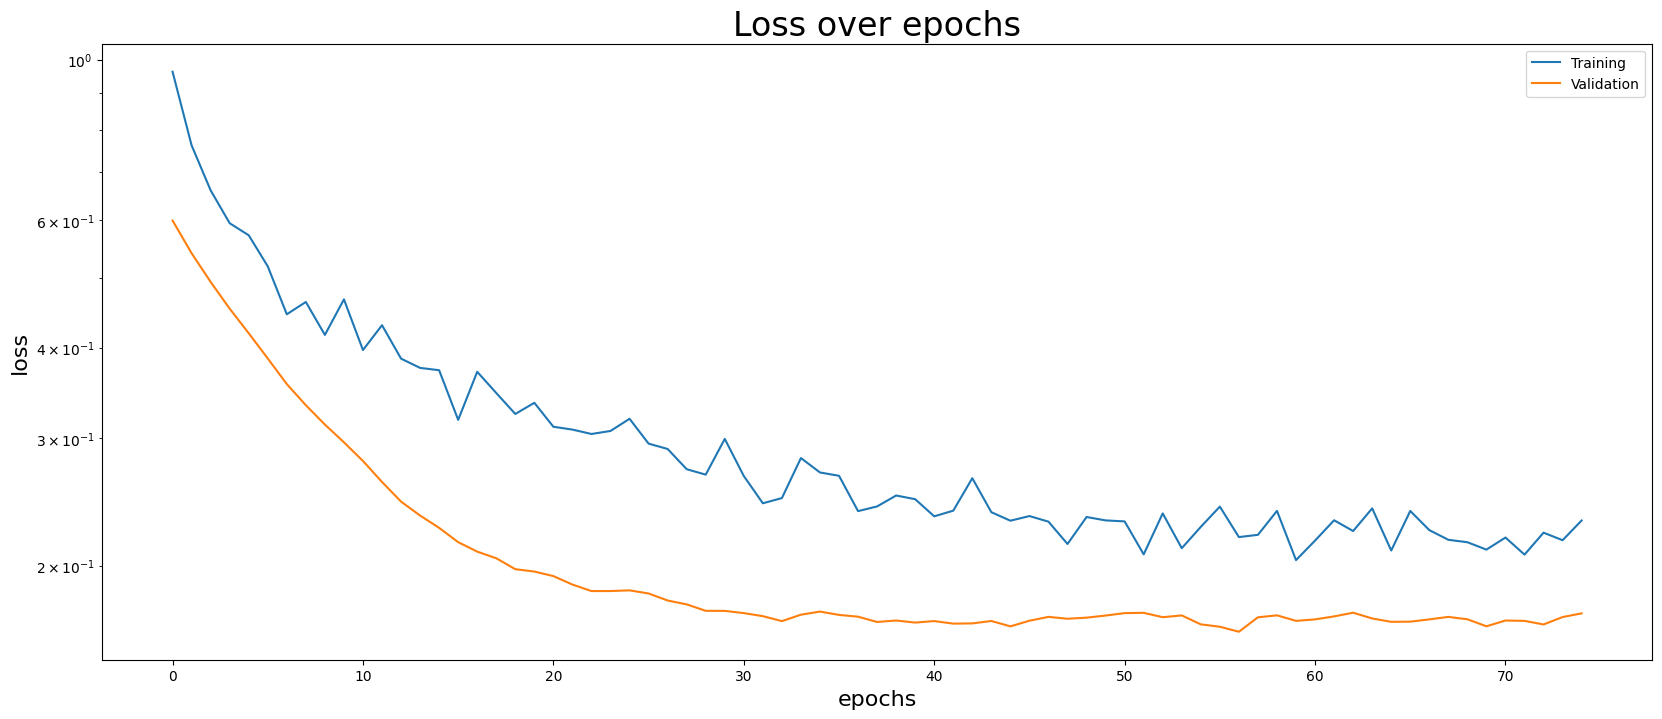

In [40]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

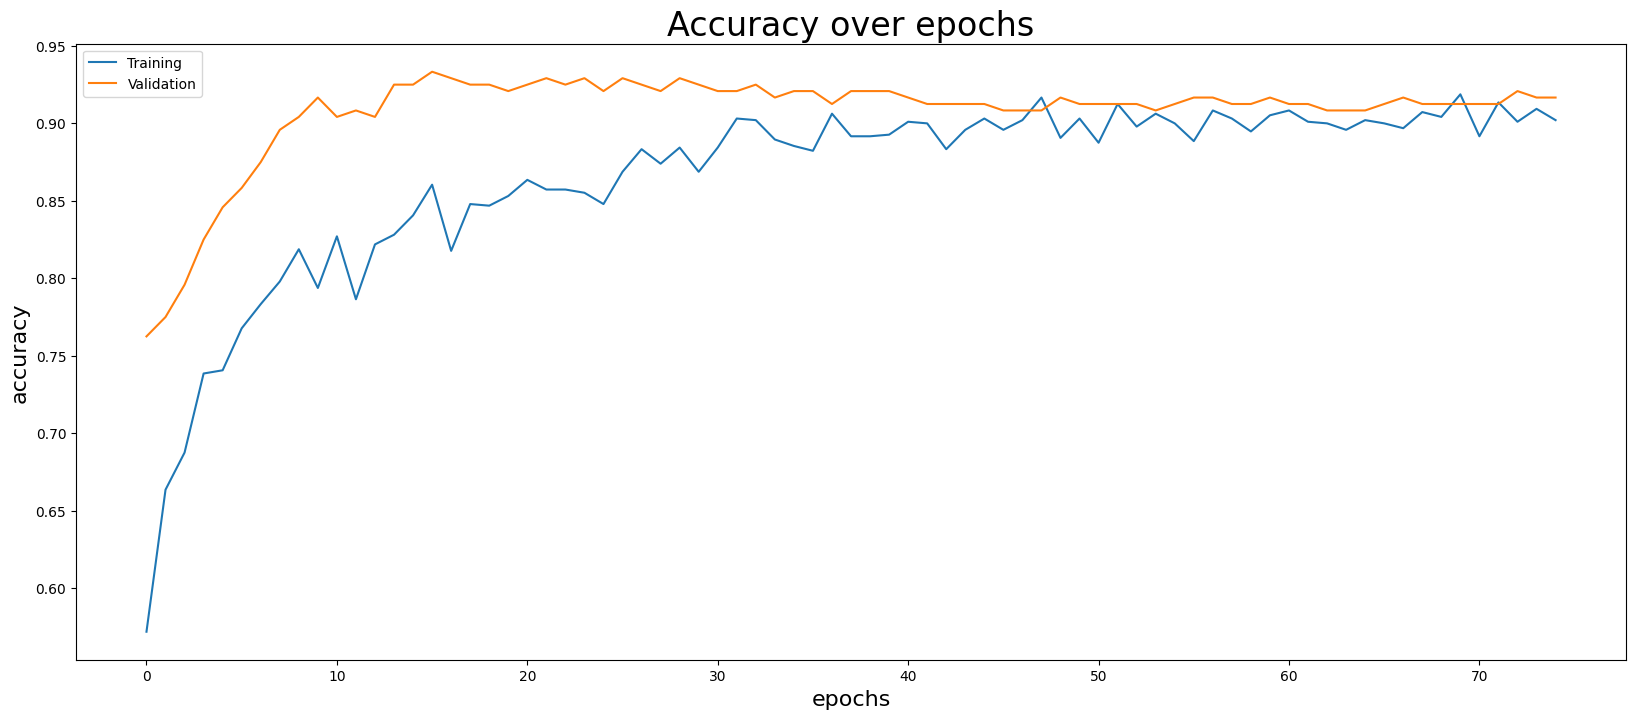

In [41]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

In [42]:
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {val_accuracy * 100:.2f}%")
val_loss, val_accuracy

Final validation accuracy: 91.67%


(0.1717887967824936, 0.9166666865348816)

In [43]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9446 - loss: 0.1390 


(0.14806267619132996, 0.9375)

In [44]:
test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9180 - loss: 0.1858 


(0.20421664416790009, 0.9166666865348816)

# Schritt 4: Bewertung anhand technischer Metriken

## Spanne der Accuracy und Check auf Overfitting

In [45]:
# 85% is sufficient for our use case
assert train_metric > .85

In [46]:
assert test_metric > .85

In [47]:
assert abs(train_metric - test_metric) < .05

In [48]:
# we can not be too good, this would be a suspicious

assert test_metric < .95
assert train_metric < .95

## Verteilung der Vorhersage

In [49]:
threshold = .5
y_pred = (model.predict(X) > threshold).astype("int32")
y_pred.shape

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(1500, 1)

In [50]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1], dtype=int32), array([847, 653]))

In [51]:
# equal distribution around classes expected
tolerance = 0.25
expected_count = len(X) / len(values)
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')

for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

562-937
847
653


# Schritt 5: Bewertung anhand von Business KPIs (Key Performance Indicator)

## Je nachdem wo man den Schnitt macht bekomt man andere Ergebnisse

In [52]:
def plot_proba_dist(X, y_true, threshold = 0.5, bins=25):
  y_hat = model.predict(X, verbose=0).squeeze()

  TP_probabilities = y_hat[(y_true == 1) & (y_hat >= threshold)]
  FP_probabilities = y_hat[(y_true == 0) & (y_hat >= threshold)]
  TN_probabilities = y_hat[(y_true == 0) & (y_hat < threshold)]
  FN_probabilities = y_hat[(y_true == 1) & (y_hat < threshold)]

  plt.figure(figsize=(10, 6))

  plt.hist(TP_probabilities, bins=bins, range=(0,1), color='blue', alpha=0.3, label='TP (True Positives)')
  plt.hist(FP_probabilities, bins=bins, range=(0,1), color='red', alpha=0.5, label='FP (False Positives)')
  plt.hist(TN_probabilities, bins=bins, range=(0,1), color='orange', alpha=0.3, label='TN (True Negatives)')
  plt.hist(FN_probabilities, bins=bins, range=(0,1), color='gray', alpha=0.5, label='FN (False Negatives)')


  # Add a vertical line for the threshold
  plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label='Schwellenwert')

  # Adding titles and labels
  plt.title('Verteilung der Wahrscheinlichkeiten')
  plt.xlabel('Wahrscheinlichkeit')
  plt.ylabel('Dichte')
  # plt.yscale('log')
  plt.legend()

  # Show the plot
  plt.grid(True)
  plt.tight_layout()
  plt.show()


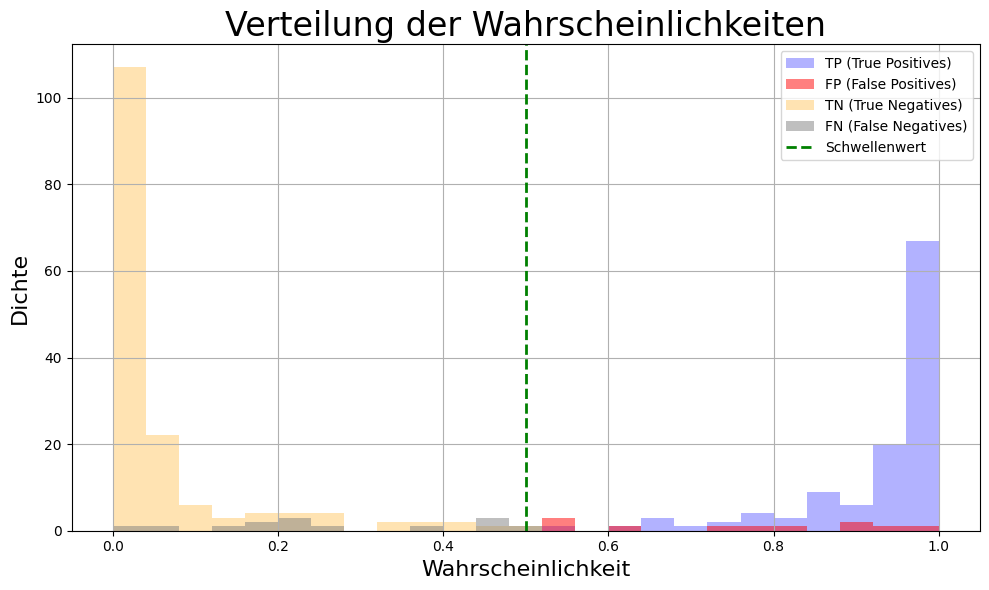

In [53]:
plot_proba_dist(X_test, y_test, threshold=0.5)

## Für Schnitt genau in der Mitte sieht es nicht so gut aus

In [54]:
y_true = y_test
threshold = .5
y_pred = (model.predict(X_test, verbose=0) > threshold).astype("int32")
# y_pred = (base_clf.predict(X_test) > threshold).astype("int32")
y_true.shape, y_pred.shape


((300,), (300, 1))

In [55]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(158, 11, 14, 117)

In [56]:
# costs and benefits
cost_fp = 5_000  # cost of a false positive
reward_tp = 1000  # reward of a true positive
cost_fn = 1000  # cost of a false negative

kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
kpi_per_case = round(kpi  / len(y_true))

print(f"KPI: ${kpi_per_case}")


KPI: $160


In [57]:
kpi = (tp * reward_tp) - (fp * cost_fp)
kpi_per_insurance = round(kpi  / tp + fp)

print(f"KPI nur für Versicherte: ${kpi_per_insurance}")

KPI nur für Versicherte: $541


## Aber wir können den Schwellenwert verschieben und so die besten KPIs berechnen

In [58]:
# kpi depends on where we make the split between good and bad customers
def kpi_for_threshold(X, y_true, threshold, use_baseline=False):
    if use_baseline:
          y_pred = (base_clf.predict(X_test) > threshold).astype("int32")
    else:
      y_pred = (model.predict(X, verbose=0) > threshold).astype("int32")

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
    kpi_per_case = round(kpi  / len(y_true))
    return kpi_per_case, (tn, fp, fn, tp)

In [59]:
kpi_per_case, (tn, fp, fn, tp) = kpi_for_threshold(X_test, y_test, threshold=.5)
kpi_per_case, (tn, fp, fn, tp)

(160, (158, 11, 14, 117))

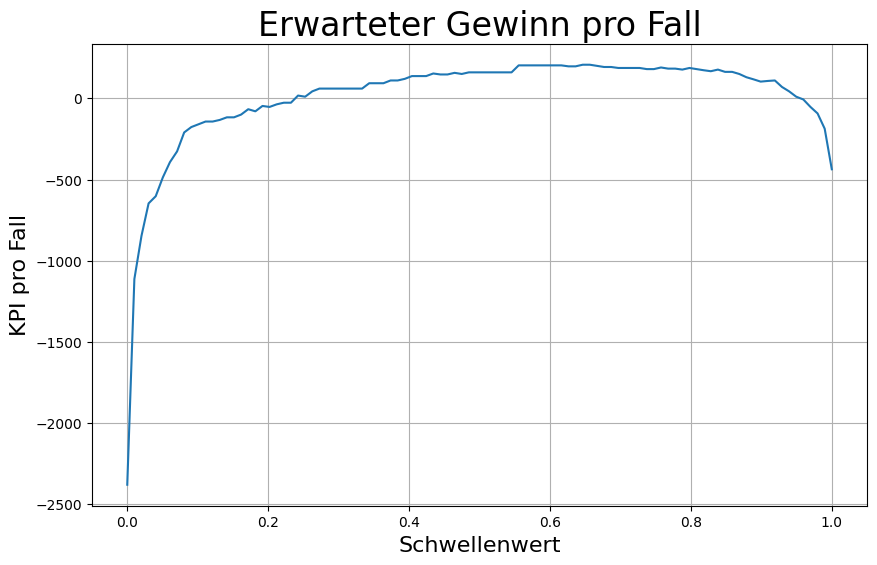

In [60]:
thresholds = np.linspace(0, 1, 100)
kpi_values = []

plt.figure(figsize=(10, 6))

# Calculate KPI for each threshold
for threshold in thresholds:
    kpi, _ = kpi_for_threshold(X_test, y_test, threshold)
    kpi_values.append(kpi)

# Plotting the results
plt.plot(thresholds, kpi_values)
plt.xlabel('Schwellenwert')
plt.ylabel('KPI pro Fall')
# plt.yscale('log')
plt.title('Erwarteter Gewinn pro Fall')
plt.grid(True)
plt.show()


In [61]:
best_kpi = max(kpi_values)
best_threshold = thresholds[np.array(kpi_values).argmax()]
_, (tn, fp, fn, tp) = kpi_for_threshold(X_test, y_test, best_threshold)
print(f"Best KPI ${best_kpi} for threshold {best_threshold}")
tn, fp, fn, tp

Best KPI $207 for threshold 0.6464646464646465


(162, 7, 17, 114)

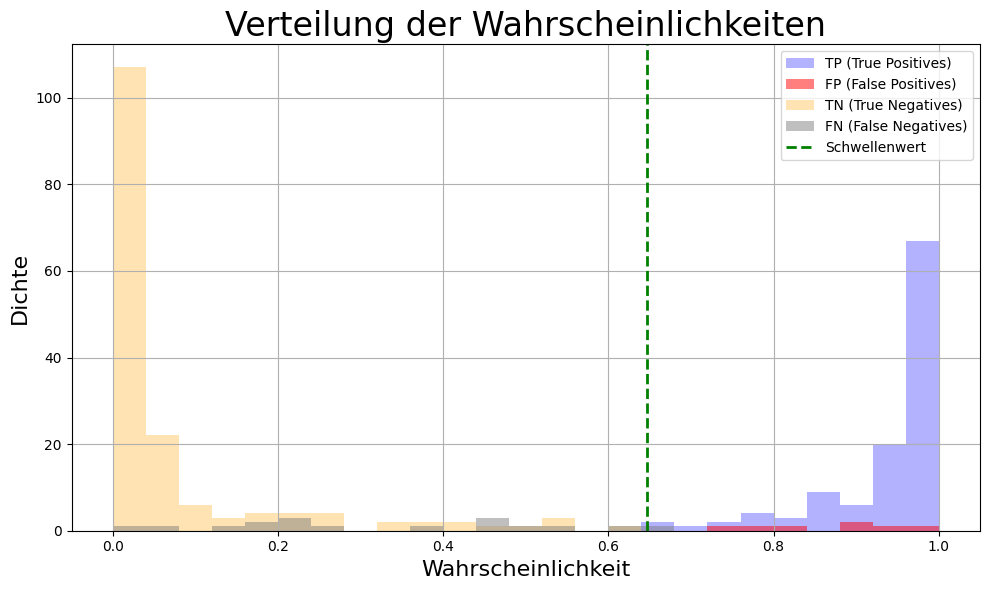

In [62]:
plot_proba_dist(X_test, y_test, threshold=best_threshold)

In [63]:
assert best_kpi > mimimum_profit_per_case

In [64]:
rate_people_getting_insurance = (tp + fp) / len(y_test)
rate_people_getting_insurance

0.4033333333333333

In [65]:
assert rate_people_getting_insurance > minimun_insurance_rate

# Schritt 6: Modell sichern

In [66]:
model.save('classifier-binary.keras', save_format='keras')